In [1]:
!pip install tensorflow

In [55]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

Import data BTC



In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyamchoksi/bitcoin-historical-prices-and-activity-2010-2024")

print("Path to dataset files:", path)

100%|██████████| 378k/378k [00:00<00:00, 30.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/priyamchoksi/bitcoin-historical-prices-and-activity-2010-2024/versions/4


In [4]:
print(os.listdir(path))

['bitcoin_2010-07-17_2024-06-28.csv', 'bitcoin_2010-07-17_2024-05-23.csv']


In [5]:
df = pd.read_csv(f"{path}/bitcoin_2010-07-17_2024-06-28.csv")

In [6]:
df.tail()

,Start,End,Open,High,Low,Close,Volume,Market Cap
5090,2010-07-21,2010-07-22,0.0792,0.0792,0.0792,0.0792,0.0,0.0
5091,2010-07-20,2010-07-21,0.0747,0.0747,0.0747,0.0747,0.0,0.0
5092,2010-07-19,2010-07-20,0.0808,0.0808,0.0808,0.0808,0.0,0.0
5093,2010-07-18,2010-07-19,0.0858,0.0858,0.0858,0.0858,0.0,0.0
5094,2010-07-17,2010-07-18,0.0500,0.0500,0.0500,0.0500,0.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095 entries, 0 to 5094
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Start       5095 non-null   object 
 1   End         5095 non-null   object 
 2   Open        5095 non-null   float64
 3   High        5095 non-null   float64
 4   Low         5095 non-null   float64
 5   Close       5095 non-null   float64
 6   Volume      5095 non-null   float64
 7   Market Cap  5095 non-null   float64
dtypes: float64(6), object(2)
memory usage: 318.6+ KB


In [8]:
df = df.iloc[::-1].reset_index(drop=True)

In [9]:
df.tail()

,Start,End,Open,High,Low,Close,Volume,Market Cap
5090,2024-06-23,2024-06-24,64276.04,64521.03,63290.43,63290.43,6.853945e+10,1.265327e+12
5091,2024-06-24,2024-06-25,63168.03,63316.01,58946.24,60382.81,8.828355e+10,1.211101e+12
5092,2024-06-25,2024-06-26,60317.99,62231.16,60272.58,61789.98,1.050312e+11,1.208415e+12
5093,2024-06-26,2024-06-27,61733.99,62357.58,60761.24,60761.24,1.017576e+11,1.210544e+12
5094,2024-06-27,2024-06-28,60882.90,62338.43,60666.19,61646.05,1.215887e+11,1.208392e+12


### Add features

In [10]:
df['10-day MA'] = df['Close'].rolling(window=10).mean()
df['50-day MA'] = df['Close'].rolling(window=50).mean()

### Data Preprocessing

In [11]:
df.isnull().sum()

,0
Start,0
End,0
Open,0
High,0
Low,0
Close,0
Volume,0
Market Cap,0
10-day MA,9
50-day MA,49


In [12]:
df.dropna(inplace=True)
df.isnull().sum()

,0
Start,0
End,0
Open,0
High,0
Low,0
Close,0
Volume,0
Market Cap,0
10-day MA,0
50-day MA,0


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
scaled

array([[4.65193338e-08],
       [3.55736082e-08],
       [3.55736082e-08],
       ...,
       [8.45419401e-01],
       [8.31344018e-01],
       [8.43450128e-01]])

In [14]:
close_series = df['Close']

def check_stationarity(series):
  result = adfuller(series.dropna())
  print("ADF Statistic:", result[0])
  print("p-value:", result[1])

  if result[1] < 0.05:
    print("The series is stationary")
  else:
    print("The series is not stationary")

check_stationarity(close_series)

ADF Statistic: -0.7027149163993718
p-value: 0.8460450594710678
The series is not stationary


In [22]:
returns = close_series.pct_change().dropna()
check_stationarity(returns)

ADF Statistic: -11.70605468274088
p-value: 1.5279912869591408e-21
The series is stationary


### Building LSTM Model

In [41]:
def create_dataset(dataset, look_back=1):
  X_data, y_data = [], []
  for i in range(len(dataset) - look_back):
    X_data.append(dataset[i: (i + look_back)])
    y_data.append(dataset[(i + look_back)])
  return np.array(X_data), np.array(y_data)

In [44]:
X_data, y_data = create_dataset(scaled, look_back=30)

train_size = int(len(X_data) * 0.7)
X_train, y_train = X_data[:train_size], y_data[:train_size]
X_test, y_test = X_data[train_size:], y_data[train_size:]

In [45]:
early_stop = EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
)

In [46]:
model = Sequential([
    LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    LSTM(units=64, return_sequences=False,),
    Dense(units=1)
    ])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

### Training & Evaluation LSTM

In [48]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
    )

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - loss: 4.5026e-04 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 4.6281e-05 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 5.4030e-05 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 3.3841e-05 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 3.5798e-05 - learning_rate: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 3.7444e-05 - learning_rate: 0.0010
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 3.3796e-05 - learning_rate: 0.0010
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 2.7311e-05 - learning_rate: 0.0010
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 3.0631e-05 - learning_rate: 0.0010
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 2.7734e-05 - learning_rate: 0.0010
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━

In [49]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_testing = scaler.inverse_transform(y_test.reshape(-1, 1))

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


In [50]:
rmse = np.sqrt(mean_squared_error(y_testing, predictions))
print(f"RMSE: {rmse}")

RMSE: 3803.3687251824736


In [52]:
plotting_data = pd.DataFrame(
    {
    'Original' : y_testing.flatten(),
    'Prediction' : predictions.flatten(),
    }, index = df['Close'].index[train_size + 30:]
    )
plotting_data['Years'] = df.loc[plotting_data.index, 'End'].values
plotting_data['Years'] = pd.to_datetime(plotting_data['Years'])

plotting_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1505 entries, 3590 to 5094
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Original    1505 non-null   float64       
 1   Prediction  1505 non-null   float32       
 2   Years       1505 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float32(1), float64(1)
memory usage: 41.2 KB


In [53]:
plotting_data.tail()

,Original,Prediction,Years
5090,63290.43,56421.453125,2024-06-24
5091,60382.81,55971.050781,2024-06-25
5092,61789.98,54280.480469,2024-06-26
5093,60761.24,54051.222656,2024-06-27
5094,61646.05,53743.156250,2024-06-28


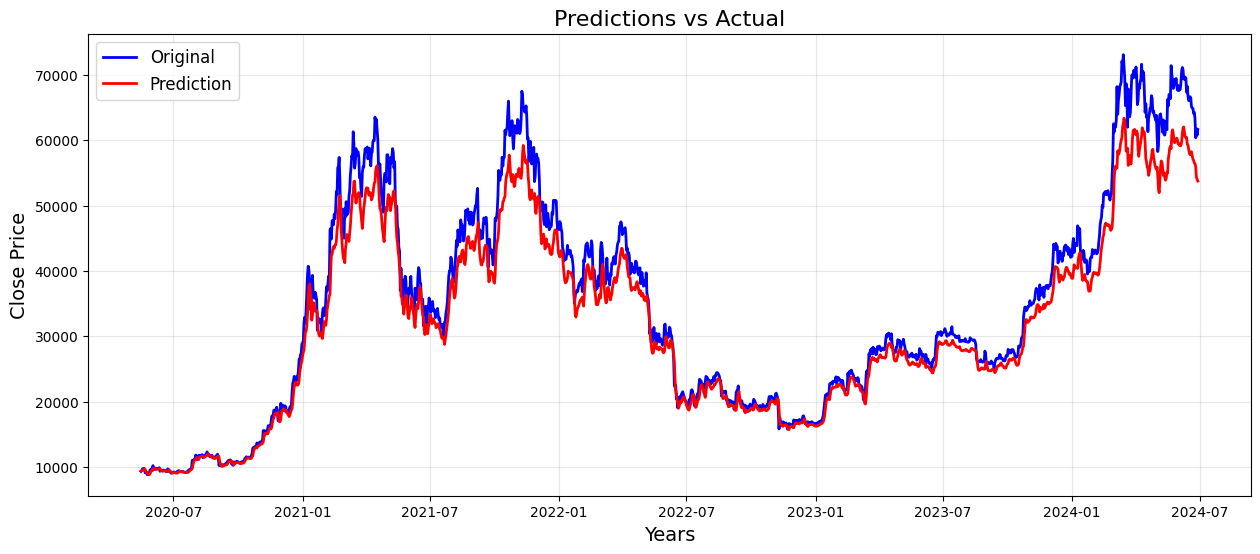

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(plotting_data['Years'], plotting_data['Original'], label='Original', color='blue', linewidth=2)
plt.plot(plotting_data['Years'], plotting_data['Prediction'], label='Prediction', color='red', linewidth=2)

plt.title("Predictions vs Actual", fontsize=16)
plt.xlabel("Years", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

### Building GRU Model

In [56]:
def create_dataset(dataset, look_back=1):
  X_data, y_data = [], []
  for i in range(len(dataset) - look_back):
    X_data.append(dataset[i: (i + look_back)])
    y_data.append(dataset[(i + look_back)])
  return np.array(X_data), np.array(y_data)

In [57]:
X_data, y_data = create_dataset(scaled, look_back=30)

train_size = int(len(X_data) * 0.7)
X_train, y_train = X_data[:train_size], y_data[:train_size]
X_test, y_test = X_data[train_size:], y_data[train_size:]

In [58]:
early_stop = EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
)

In [59]:
model = Sequential([
    GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    GRU(units=64, return_sequences=False,),
    Dense(units=1)
    ])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

### Training & Evaluation LSTM

In [61]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
    )

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 3.5779e-04 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 2.6797e-05 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 2.9000e-05 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 2.9045e-05 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 2.4046e-05 - learning_rate: 0.0010
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 1.8945e-05 - learning_rate: 0.0010
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 2.1771e-05 - learning_rate: 0.0010
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 2.4390e-05 - learning_rate: 0.0010
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 1.7481e-05 - learning_rate: 0.0010
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 2.3781e-05 - learning_rate: 0.0010
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━

In [62]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_testing = scaler.inverse_transform(y_test.reshape(-1, 1))

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [63]:
rmse = np.sqrt(mean_squared_error(y_testing, predictions))
print(f"RMSE: {rmse}")

RMSE: 2563.060585294798


In [64]:
plotting_data = pd.DataFrame(
    {
    'Original' : y_testing.flatten(),
    'Prediction' : predictions.flatten(),
    }, index = df['Close'].index[train_size + 30:]
    )
plotting_data['Years'] = df.loc[plotting_data.index, 'End'].values
plotting_data['Years'] = pd.to_datetime(plotting_data['Years'])

plotting_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1505 entries, 3590 to 5094
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Original    1505 non-null   float64       
 1   Prediction  1505 non-null   float32       
 2   Years       1505 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float32(1), float64(1)
memory usage: 41.2 KB


In [65]:
plotting_data.tail()

,Original,Prediction,Years
5090,63290.43,59796.828125,2024-06-24
5091,60382.81,58955.867188,2024-06-25
5092,61789.98,56387.992188,2024-06-26
5093,60761.24,57606.226562,2024-06-27
5094,61646.05,56834.476562,2024-06-28


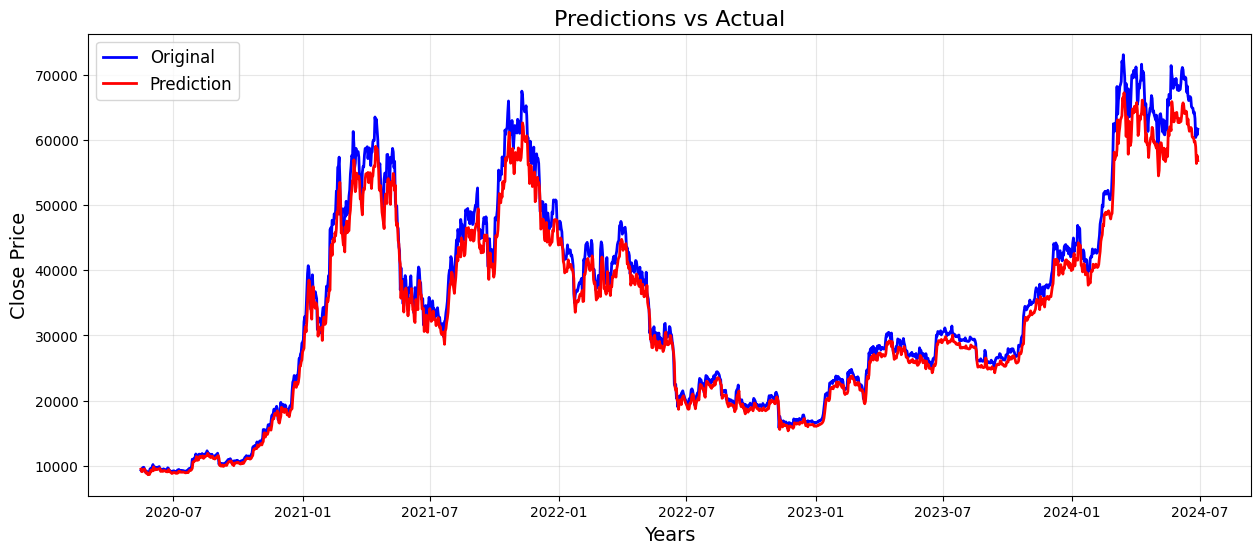

In [66]:
plt.figure(figsize=(15, 6))
plt.plot(plotting_data['Years'], plotting_data['Original'], label='Original', color='blue', linewidth=2)
plt.plot(plotting_data['Years'], plotting_data['Prediction'], label='Prediction', color='red', linewidth=2)

plt.title("Predictions vs Actual", fontsize=16)
plt.xlabel("Years", fontsize=14)
plt.ylabel("Close Price", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

In [67]:
model.save('model_prediction_BTC_GRU.keras')